[Data] Loading FB15k-237 from /content/train.txt...
[Data] Loaded 272115 triples.
[Pipeline] Building and visualizing FB15k-237 knowledge graph...


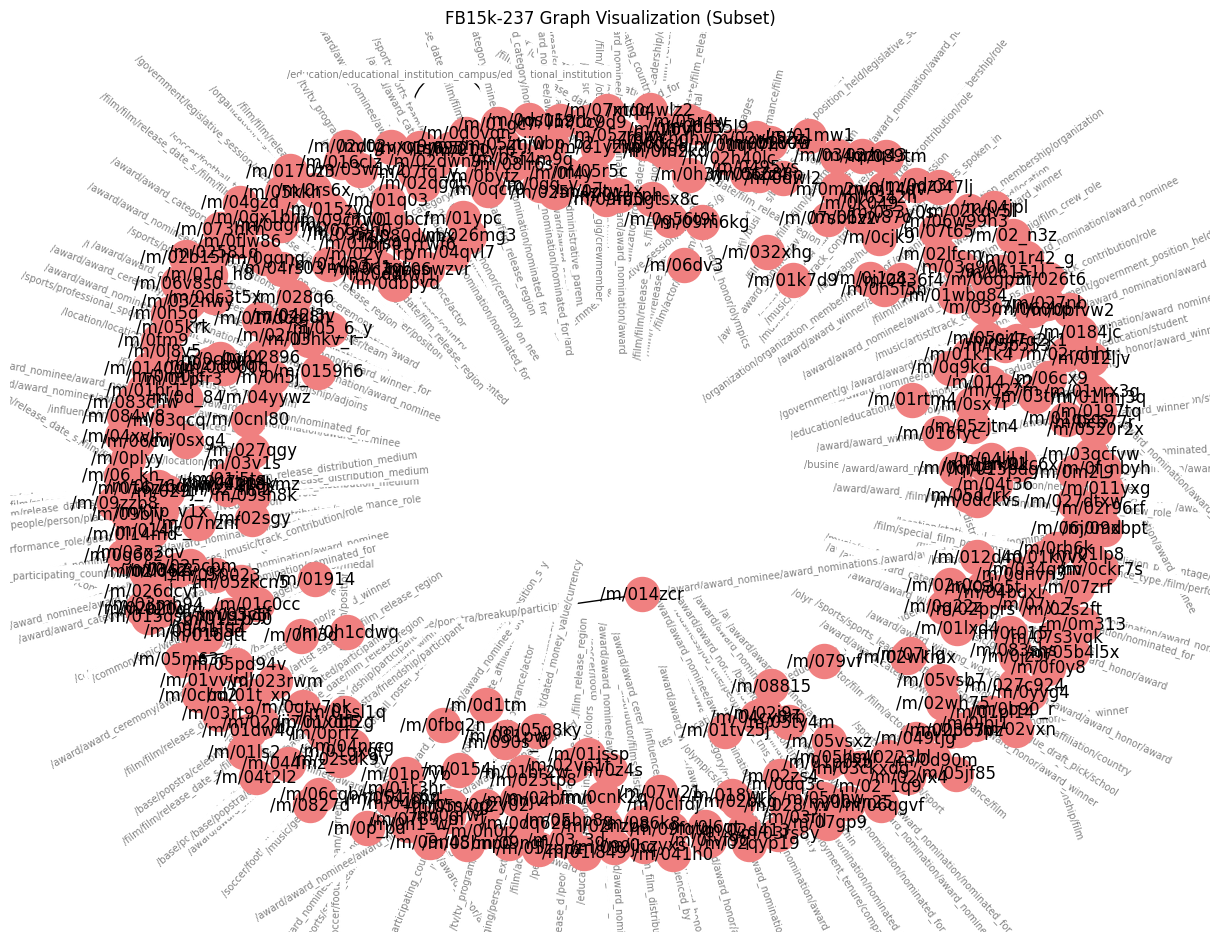

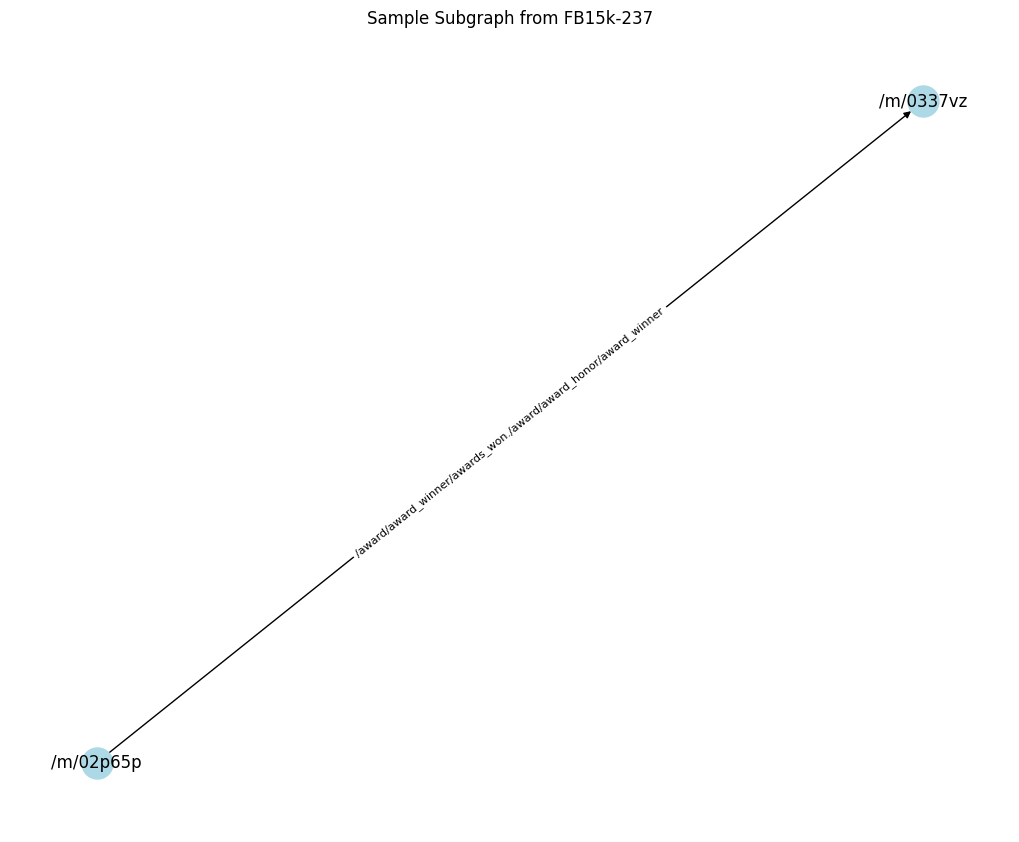

In [12]:
import os
import torch
import random
from itertools import islice
from typing import List, Tuple, Dict
import networkx as nx
import matplotlib.pyplot as plt

# === Load FB15k-237 triples ===
print("[Data] Loading FB15k-237 from /content/train.txt...")
triplets: List[Tuple[str, str, str]] = []
with open("/content/train.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) == 3:
            triplets.append((parts[0], parts[1], parts[2]))
print(f"[Data] Loaded {len(triplets)} triples.")

# === Graph Builders ===
def build_and_visualize_graph(triplets: List[Tuple[str, str, str]]):
    G = nx.MultiDiGraph()
    for h, r, t in triplets:
        G.add_node(h, node_type="head")
        G.add_node(t, node_type="tail")
        G.add_edge(h, t, relation=r)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 9))
    nx.draw(G, pos, with_labels=True, node_size=600, node_color="lightcoral", arrows=True)
    edge_labels = {(u, v): d["relation"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="gray", font_size=7)
    plt.title("FB15k-237 Graph Visualization (Subset)")
    plt.axis("off")
    plt.show()
    return G

def visualize_sample_subgraph(G, n_nodes=20):
    if G.number_of_nodes() == 0:
        print("Graph is empty.")
        return
    start = random.choice(list(G.nodes))
    sub_nodes = list(islice(nx.bfs_tree(G.to_undirected(), start), n_nodes))
    H = G.subgraph(sub_nodes)
    pos = nx.spring_layout(H)
    plt.figure(figsize=(10, 8))
    nx.draw(H, pos, with_labels=True, node_size=500, node_color="lightblue", arrows=True)
    edge_labels = {(u, v): d["relation"] for u, v, d in H.edges(data=True)}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Sample Subgraph from FB15k-237")
    plt.axis("off")
    plt.show()

# === MAIN PIPELINE ===
print("[Pipeline] Building and visualizing FB15k-237 knowledge graph...")
G = build_and_visualize_graph(triplets[:200])  # visualizing a smaller subset for clarity
visualize_sample_subgraph(G)


[Data] Loading YAGO3-10 from /content/train.csv...
[Data] Loaded 1079041 triples.
[Pipeline] Building YAGO3-10 graph...


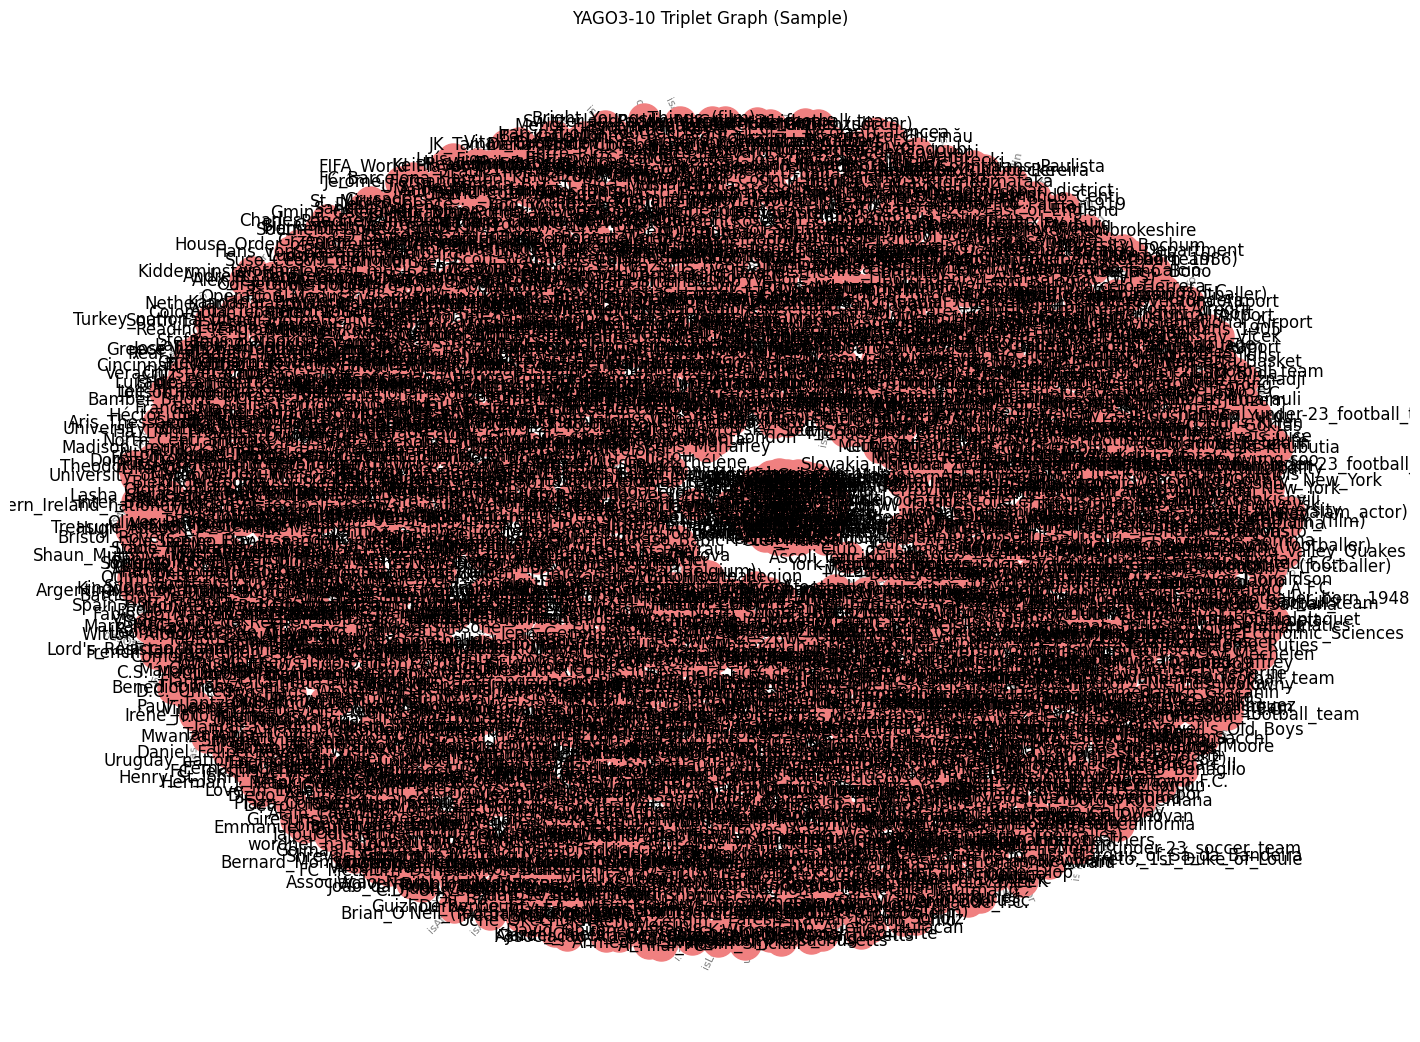

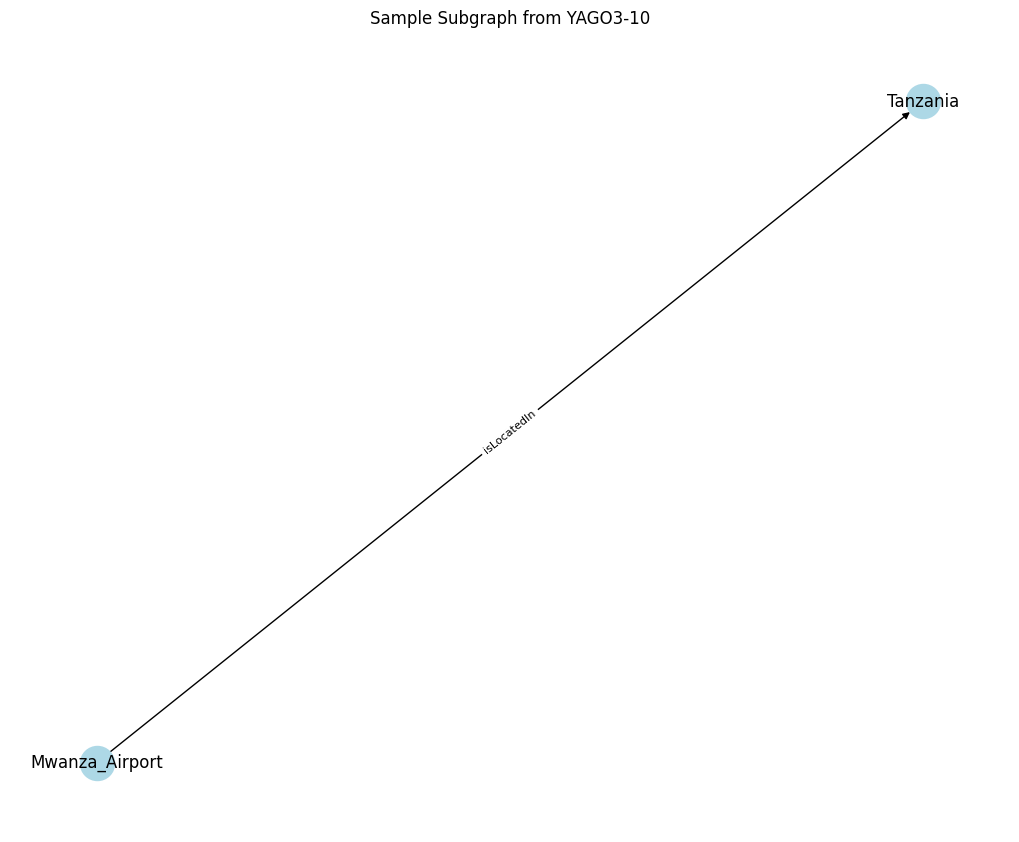

In [2]:
import os
import pandas as pd
import torch
import random
from itertools import islice
from typing import List, Tuple
import networkx as nx
import matplotlib.pyplot as plt

# === Load YAGO3-10 triples ===
print("[Data] Loading YAGO3-10 from /content/train.csv...")
df = pd.read_csv("/content/train.csv", header=None)
df.columns = ["head", "relation", "tail"]

triplets: List[Tuple[str, str, str]] = list(df.itertuples(index=False, name=None))
print(f"[Data] Loaded {len(triplets)} triples.")

# === Graph Builder and Visualizer ===
def build_and_visualize_graph(triplets: List[Tuple[str, str, str]], max_edges=1000):
    G = nx.MultiDiGraph()
    for h, r, t in triplets[:max_edges]:
        G.add_node(h, node_type="entity")
        G.add_node(t, node_type="entity")
        G.add_edge(h, t, relation=r)

    if G.number_of_nodes() == 0:
        print("[Warning] Graph is empty.")
        return G

    pos = nx.spring_layout(G, seed=42, k=0.6)
    plt.figure(figsize=(14, 10))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightcoral", arrows=True)
    edge_labels = {(u, v): d["relation"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="gray", font_size=8)
    plt.title("YAGO3-10 Triplet Graph (Sample)")
    plt.axis("off")
    plt.show()
    return G

# === Subgraph Visualizer ===
def visualize_sample_subgraph(G, n_nodes=25):
    if G.number_of_nodes() == 0:
        print("Graph is empty.")
        return
    start = random.choice(list(G.nodes))
    sub_nodes = list(islice(nx.bfs_tree(G.to_undirected(), start), n_nodes))
    H = G.subgraph(sub_nodes)
    pos = nx.spring_layout(H)
    plt.figure(figsize=(10, 8))
    nx.draw(H, pos, with_labels=True, node_size=600, node_color="lightblue", arrows=True)
    edge_labels = {(u, v): d["relation"] for u, v, d in H.edges(data=True)}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Sample Subgraph from YAGO3-10")
    plt.axis("off")
    plt.show()

# === MAIN PIPELINE ===
print("[Pipeline] Building YAGO3-10 graph...")
G = build_and_visualize_graph(triplets, max_edges=1000)
visualize_sample_subgraph(G, n_nodes=25)


In [ ]:
# independent components
n_comp = nx.number_weakly_connected_components(G)
sizes  = [len(c) for c in nx.weakly_connected_components(G)]
print(f"[Diag] {n_comp} weakly-connected components "
      f"(largest = {max(sizes)} nodes)")

In [ ]:
# convert to undirected to find components and bridging nodes
undirected = G.to_undirected()

# find connected components
components = list(nx.connected_components(undirected))
print(f"Graph has {len(components)} connected components.")

# count how many components each node appears in (based on neighbors)
node_to_components = {}
for i, comp in enumerate(components):
    for node in comp:
        node_to_components[node] = i

# find nodes that connect multiple nodes i.e. appear multiple times in dataset
bridge_candidates = [node for node in G.nodes if G.degree[node] > 1]

# sort by degree
sorted_bridges = sorted(bridge_candidates, key=lambda n: G.degree[n], reverse=True)

# print the top bridge nodes
print("\nTop bridge-like nodes (shared across courses):")
for node in sorted_bridges[:10]:  # adjust number as needed
    print(f"- {node} (degree: {G.degree[node]}, type: {G.nodes[node].get('node_type', 'unknown')})")


Graph has 8 connected components.

Top bridge-like nodes (shared across courses):
- Deep Learning (degree: 56, type: entity)
- Machine Learning (degree: 52, type: entity)
- Introduction to Machine Learning (degree: 31, type: entity)
- Introduction to Deep Learning (degree: 21, type: entity)
- Convex Optimization (degree: 18, type: entity)
- 2018 (degree: 13, type: entity)
- Statistical Machine Learning (degree: 13, type: entity)
- 2019 (degree: 12, type: entity)
- 2015 (degree: 11, type: entity)
- Neural Networks (degree: 11, type: entity)
